In [5]:
import os
import glob
import numpy as np 
import xarray as xr
import pandas as pd
import datetime
from datetime import date, timedelta
import dask
import re
import scipy.stats as stats
import scipy.signal as signal
from skimage.measure import find_contours
from statsmodels.tsa.stattools import acf, pacf

# Plotting utils 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy
import cartopy.crs as ccrs
import seaborn as sns


## Define functions

In [1]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds
    
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def get_region(minLat,maxLat,minLon,maxLon, DS, ocnDS = [], ocnMask=False): 
    iLat  = np.where( (DS['lat']>=minLat) & (DS['lat']<=maxLat) )[0]
    iLon  = np.where( (DS['lon']>=minLon) & (DS['lon']<=maxLon) )[0]
    
    if ocnMask==True:
        selOcn = ocnDS[iLat,:]
        
        return selOcn[:,iLon]
            
    return DS.isel(lat=iLat, lon=iLon)

def wgt_rmse(fld1, fld2, wgt):
    """Calculate the area-weighted RMSE.

    Parameters
    ----------
    fld1, fld2 : array-like
        2-dimensional spatial fields with the same shape.
        They can be xarray DataArray or numpy arrays.
    wgt : array-like
        the weight vector, expected to be 1-dimensional,
        matching length of one dimension of the data.

    Returns
    -------
    float
        root mean squared error

    Notes:
    ```rmse = sqrt( mean( (fld1 - fld2)**2 ) )```
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.sum(warray * (fld1 - fld2)**2)
    
    return np.sqrt( wmse ).item()

    

In [2]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

# def preprocess_h0(ds):
    
#     keepVars_noGust = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS',
#                     'U10','CLDHGH','CLDLIQ','TMQ',
#                     'CDNUMC','CLDLOW',
#                     'CLDMED','CLDTOT','RVMTEND_CLUBB','STEND_CLUBB',
#                     'T','Q','OMEGA','PBLH','U','V','Z3',
#                     'PRECT','PRECC','PRECL','LANDFRAC','OCNFRAC', 'ICEFRAC',
#                     'TGCLDLWP','LHFLX','SHFLX','TREFHT', 'TAUX','TAUY',
#                     'hyam','hybm','hyai','hybi']
#     # keepVars_gust = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS',
#     #                 'U10', 'UGUST','CLDHGH','CLDLIQ','TMQ',
#     #                 'PHIS','CDNUMC','CLDLOW',
#     #                 'CLDMED','CLDTOT','RVMTEND_CLUBB','STEND_CLUBB',
#     #                 'T','Q','OMEGA','PBLH','U','V','Z3',
#     #                 'PRECT','PRECC','PRECL','LANDFRAC','OCNFRAC','ICEFRAC',
#     #                 'TGCLDLWP','LHFLX','SHFLX','TREFHT', 'TAUX','TAUY', 
#     #                 'hyam','hybm','hyai','hybi']        
        
#     # ds['time'] = ds.indexes['time'].to_datetimeindex() 
#     varnames = list(ds.keys())

#     if 'UGUST' in varnames: 
#         dsSel      = ds[keepVars_gust]
#     else: 
#         dsSel      = ds[keepVars_noGust]
#         #dsSel['UGUST'] = (('time','lat','lon'), np.full([len(dsSel.time.values), len(dsSel.lat.values), len(dsSel.lon.values)], 0))
    
#     return dsSel


def preprocess_h0(ds):
    
    keepVars_noGust = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS',
                    'U10','CLDHGH','CLDLIQ','TMQ',
                    'CDNUMC','CLDLOW',
                    'CLDMED','CLDTOT','RVMTEND_CLUBB','STEND_CLUBB',
                    'T','Q','OMEGA','PBLH','U','V','Z3',
                    'PRECT','PRECC','PRECL','LANDFRAC','OCNFRAC', 'ICEFRAC',
                    'TGCLDLWP','LHFLX','SHFLX','TREFHT', 'TAUX','TAUY',
                    'hyam','hybm','hyai','hybi']

    dsSel      = ds[keepVars_noGust]
    
    return dsSel



In [3]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [10]:
import dask
dask.config.set({'logging.distributed': 'error'})

from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="06:00:00",
    project="P93300642",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39611 instead
  warnings.warn(
/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.03s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to

## Start dask

In [11]:
from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mdfowler/proxy/39611/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mdfowler/proxy/39611/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:46857,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mdfowler/proxy/39611/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
cluster.scale(24)


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [13]:
client.wait_for_workers(24)


## Read in data

In [6]:
%%time 
dir112 = '/glade/derecho/scratch/gmarques/archive/b.e30_alpha03d.BLT1850.ne30_t232_wgx3.112/atm/hist/'
listFiles112_h0 = np.sort(glob.glob(dir112+'*cam.h0a.????-*'))
ds_112 = xr.open_mfdataset(listFiles112_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal', parallel=True)
print('Case 112 read in')

Case 112 read in


In [7]:
%%time
dir104 = '/glade/derecho/scratch/hannay/archive/b.e30_beta02.BLT1850.ne30_t232.104/atm/hist/'
listFiles104_h0 = np.sort(glob.glob(dir104+'*cam.h0a.????-*'))
ds_104 = xr.open_mfdataset(listFiles104_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal')
print('Case 104 read in')

Case 104 read in
CPU times: user 3min 57s, sys: 19.9 s, total: 4min 17s
Wall time: 5min 40s


In [8]:
%%time
dir98 = '/glade/derecho/scratch/hannay/archive/b.e23_alpha17f.BLT1850.ne30_t232.098/atm/hist/'
listFiles98_h0 = np.sort(glob.glob(dir98+'*cam.h0a.????-*'))
ds_98 = xr.open_mfdataset(listFiles98_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal', parallel=True)
print('Case 98 read in')

Case 98 read in
CPU times: user 11min 23s, sys: 1min 6s, total: 12min 29s
Wall time: 22min 50s


In [9]:
%%time 
dir93 = '/glade/derecho/scratch/hannay/archive/b.e23_alpha17f.BLT1850.ne30_t232.093/atm/hist/'
listFiles93_h0 = np.sort(glob.glob(dir93+'*cam.h0a.????-*'))
ds_93 = xr.open_mfdataset(listFiles93_h0,  preprocess=preprocess_h0, concat_dim='time', 
                            combine='nested', decode_times=True, 
                            data_vars='minimal', parallel=True)
print('Case 93 read in')

Case 93 read in
CPU times: user 1min 57s, sys: 11.4 s, total: 2min 8s
Wall time: 3min 4s


In [10]:
ds_112      = ds_112.squeeze().assign_coords({"case":  '112'})
ds_104      = ds_104.squeeze().assign_coords({"case":  '104'})
ds_98       = ds_98.squeeze().assign_coords({"case":  '98'})
ds_93       = ds_93.squeeze().assign_coords({"case":  '93'})



### Read in observations? 

## Make plots

In [15]:
def getAnnMean(DS):
    month_length = DS.time.dt.days_in_month
    weights = ( month_length / month_length.sum() )
    # Calculate the weighted average
    ds_AnnWgt = (DS * weights).sum(dim="time")

    return ds_AnnWgt

In [16]:
ds_112_AnnWeighted = getAnnMean(ds_112)
ds_104_AnnWeighted = getAnnMean(ds_104)
ds_98_AnnWeighted  = getAnnMean(ds_98)
ds_93_AnnWeighted  = getAnnMean(ds_93)


In [21]:
longrid112,latgrid112  = np.meshgrid(ds_112_AnnWeighted['lon'], ds_112_AnnWeighted['lat'] )
longrid104,latgrid104  = np.meshgrid(ds_104_AnnWeighted['lon'], ds_104_AnnWeighted['lat'] )
longrid98, latgrid98   = np.meshgrid(ds_98_AnnWeighted['lon'],  ds_98_AnnWeighted['lat']  )
longrid93, latgrid93   = np.meshgrid(ds_93_AnnWeighted['lon'],  ds_93_AnnWeighted['lat']  )


[None, None, None, None]

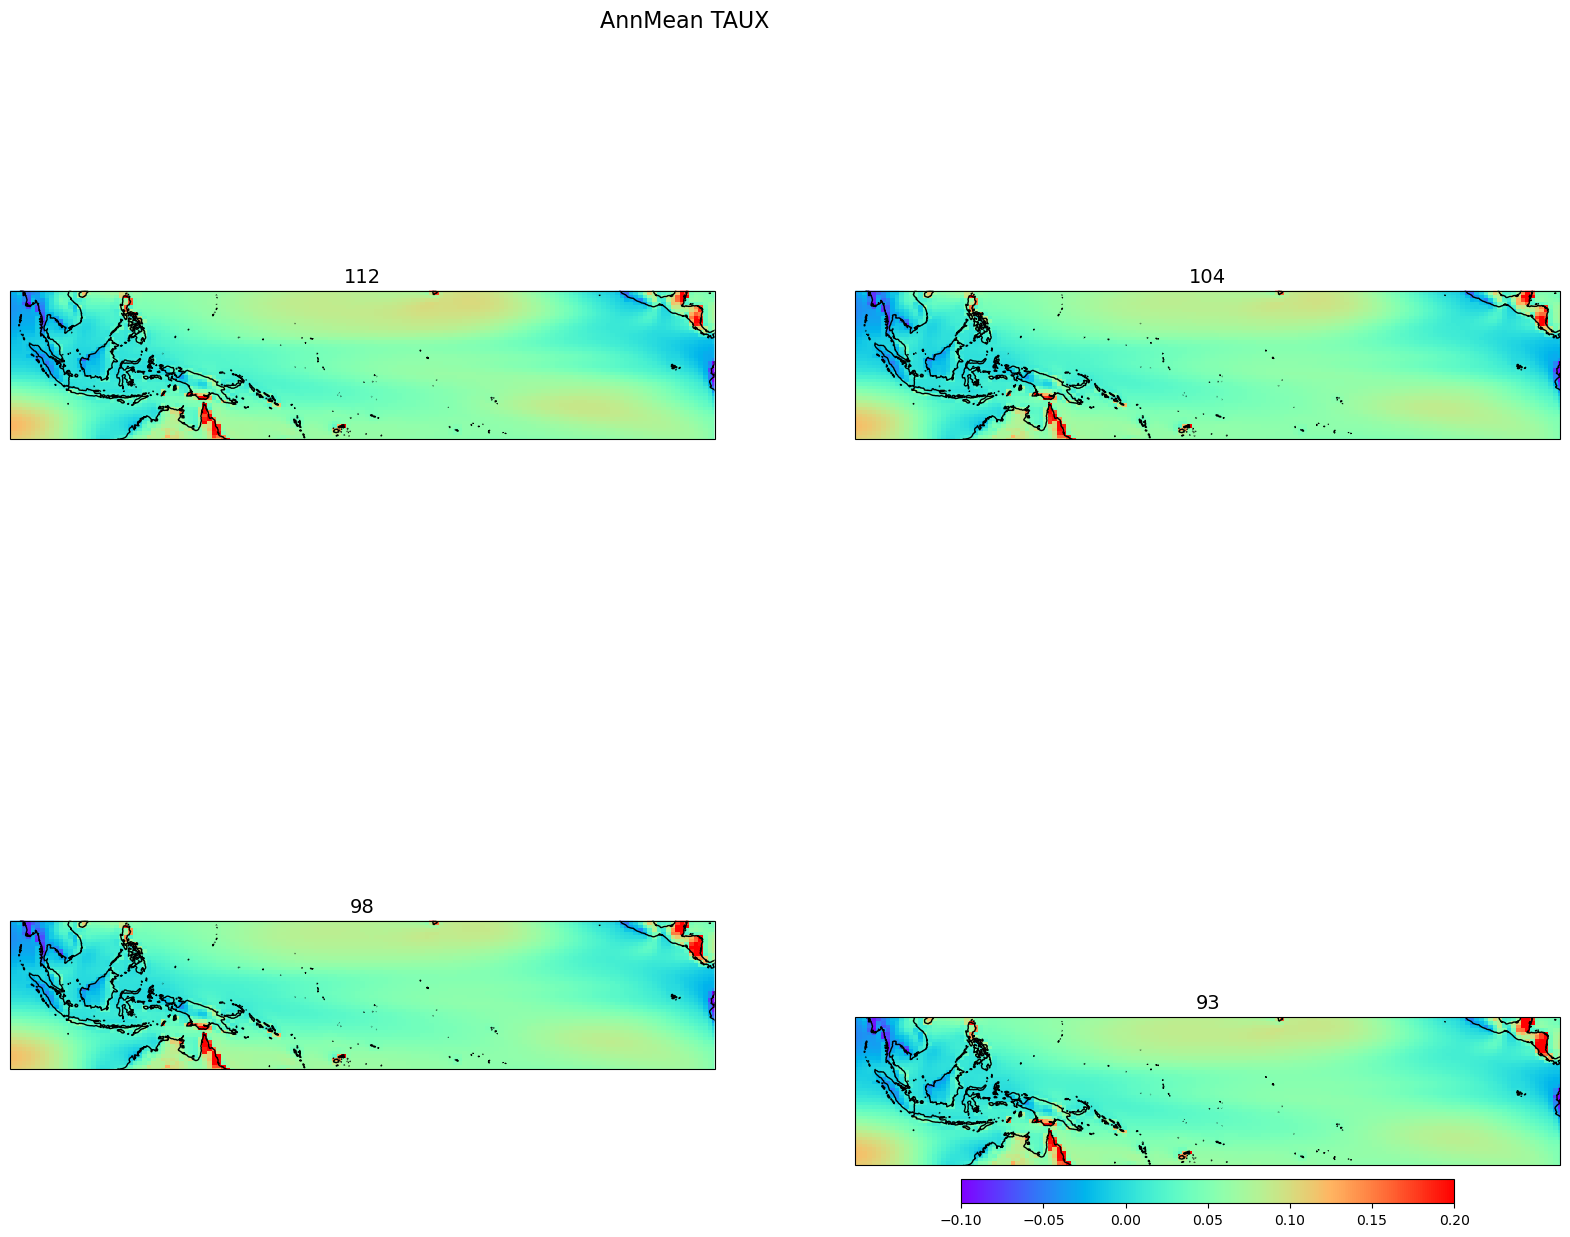

In [25]:
varSel  = 'TAUX'
normVar = matplotlib.colors.Normalize(vmin=-0.1, vmax=0.2)

fig,axs = plt.subplots(2,2,figsize=(20,15), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
axs     = axs.ravel() 
plt.gcf().text(0.42, 0.93, 'AnnMean '+varSel, fontsize=16)


axs[0].pcolormesh(longrid112, latgrid112, ds_112_AnnWeighted[varSel].values, 
                  transform=ccrs.PlateCarree(), norm=normVar, cmap='rainbow')
axs[0].set_title('112', fontsize=14)


axs[1].pcolormesh(longrid104, latgrid104, ds_104_AnnWeighted[varSel].values, 
                  transform=ccrs.PlateCarree(), norm=normVar, cmap='rainbow')
axs[1].set_title('104', fontsize=14)


axs[2].pcolormesh(longrid98, latgrid98, ds_98_AnnWeighted[varSel].values, 
                  transform=ccrs.PlateCarree(), norm=normVar, cmap='rainbow')
axs[2].set_title('98', fontsize=14)


axs[3].pcolormesh(longrid93, latgrid93, ds_93_AnnWeighted[varSel].values, 
                  transform=ccrs.PlateCarree(), norm=normVar, cmap='rainbow')
axs[3].set_title('93', fontsize=14)


cb1 = fig.colorbar(matplotlib.cm.ScalarMappable(norm=normVar, cmap='rainbow'), ax=axs[3], shrink=0.7, 
                      label='', orientation='horizontal', pad=0.025) 

[a.coastlines() for a in axs]
[a.set_extent([90,280,-20,20], crs=ccrs.PlateCarree()) for a in axs]
